In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
129742,I don't really feel like reading.,Je ne suis pas vraiment d'humeur à lire.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
157924,"Feeling the house shake, I ran outside.","Sentant la maison bouger, je suis sorti dehors...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
147792,The basketball needs to be inflated.,Le ballon de basket a besoin d'être gonflé.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
165979,I want to give you the chance to do that.,Je veux te procurer l'occasion de faire ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
141900,I'm not mentally prepared for that.,Je ne suis pas mentalement préparé à cela.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines.sample(5)

,eng,fra
20275,She disliked him.,Elle ne l'aimait pas.
26256,They look healthy.,Ils ont l'air en bonne santé.
31840,That sounds stupid.,Ça a l'air stupide.
3845,Take a seat.,Assieds-toi !
20342,Show us the room.,Montre-nous la chambre.


Step 1. 정제, 정규화, 전처리

1. 구두점(Punctuation)을 단어와 분리

In [4]:
import string # 구두점 정규화 표현식
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [5]:
puctuation = r'[\!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'
lines["eng"] = lines["eng"].str.replace(puctuation, r' \g<0> ', regex=True)

2. 띄어쓰기 단위로 토큰화 + 소문자로 바꾸기

In [6]:
eng_tokenizer = Tokenizer(lower=True, split = ' ', filters='\t\n')
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:5]

[[25, 1], [25, 1], [25, 1], [25, 1], [783, 1]]

In [7]:
lines.eng[17808]

"Don't touch this ! "

In [8]:
input_text[17808]

[28, 359, 14, 20]

In [9]:
decode = eng_tokenizer.sequences_to_texts(input_text)
decode[17808]

"don't touch this !"

In [10]:
# eng_tokenizer.word_docs

Step 2. 디코더의 문장에 시작 토큰과 종료 토큰 추가

In [11]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
lines.sample(5)

,eng,fra
9686,Buy me a drink .,\t Offrez-moi un verre ! \n
15048,It was too hard .,\t C'était trop difficile. \n
24249,I need more power .,\t J'ai besoin de plus d'électricité. \n
13752,He sells whisky .,\t Il vend du whisky. \n
32973,Was it interesting ?,\t Était-ce intéressant ? \n


Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [12]:
puctuation = r'[\!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'
lines["fra"] = lines["fra"].str.replace(puctuation, r' \g<0> ', regex=True)

In [13]:
fra_tokenizer = Tokenizer(lower=True,
                          split = ' ',
                          filters='')
fra_tokenizer.fit_on_texts(lines.fra)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:5]

[[1, 64, 8, 2],
 [1, 356, 3, 2],
 [1, 26, 504, 8, 2],
 [1, 735, 8, 2],
 [1, 781, 8, 2]]

In [14]:
lines['fra'][79]

'\t Achetez - la  !  \n'

In [15]:
target_text[79]

[1, 2302, 5, 20, 8, 2]

In [16]:
sequnces2texts = fra_tokenizer.sequences_to_texts(target_text)
sequnces2texts[79]

'\t achetez - la ! \n'

In [17]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 10021


In [18]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [19]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 10021
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [20]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [21]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 64, 8], [1, 356, 3], [1, 26, 504, 8]]
[[64, 8, 2], [356, 3, 2], [26, 504, 8, 2]]


In [22]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [23]:
print(encoder_input[0])

[25  1  0  0  0  0  0  0]


In [24]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

In [25]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 16)


Step 4. 임베딩 층(Embedding layer) 사용하기

In [26]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Masking, Dense

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 128)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [27]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb =  Embedding(fra_vocab_size, 128)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

In [28]:
import keras
decoder_dropout = keras.layers.Dropout(0.5)(decoder_outputs)
decoder_batchnorm = keras.layers.LayerNormalization()(decoder_outputs)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

Step 5. 모델 구현하기

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model

tf.random.set_seed(2022)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    615680      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1282688     input_2[0][0]                    
______________________________________________________________________________________________

In [30]:
model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    epochs=10,
                    batch_size=128,
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 12s 34ms/step - loss: 2.4123 - accuracy: 0.6718 - val_loss: 1.9851 - val_accuracy: 0.7238
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 1.5801 - accuracy: 0.7606 - val_loss: 1.7817 - val_accuracy: 0.7372
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 1.4009 - accuracy: 0.7822 - val_loss: 1.6558 - val_accuracy: 0.7565
Epoch 4/10
235/235 [==============================] - 7s 32ms/step - loss: 1.2863 - accuracy: 0.7946 - val_loss: 1.5732 - val_accuracy: 0.7653
Epoch 5/10
235/235 [==============================] - 7s 32ms/step - loss: 1.1751 - accuracy: 0.8085 - val_loss: 1.4699 - val_accuracy: 0.7758
Epoch 6/10
235/235 [==============================] - 8s 32ms/step - loss: 1.0614 - accuracy: 0.8248 - val_loss: 1.3993 - val_accuracy: 0.7891
Epoch 7/10
235/235 [==============================] - 8s 32ms/step - loss: 0.9784 - accuracy: 0.8349 - val_loss: 1.3539 - val_accuracy: 0.796

In [31]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


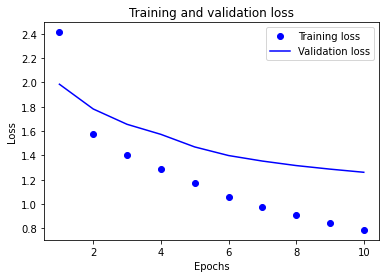

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

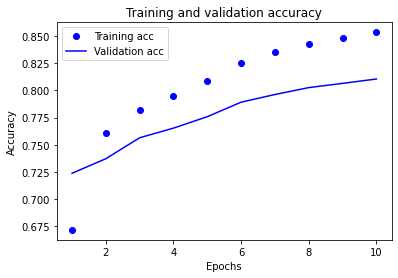

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Step 6. 모델 평가하기

In [34]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         615680    
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 394240    
Total params: 1,009,920
Trainable params: 1,009,920
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [36]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1282688     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [37]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [38]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [39]:
import numpy as np
for seq_index in [0, 60, 490, 630, 890]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-' * 35)
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go . 
정답 문장:  Va  !  
번역기가 번역한 문장:  va - nous . 
-----------------------------------
입력 문장: Relax . 
정답 문장:  Détends - toi  !  
번역기가 번역한 문장:  détends - toi ! 
-----------------------------------
입력 문장: Get away ! 
정답 문장:  Fous le camp  !  
번역기가 번역한 문장:  va - vous ! 
-----------------------------------
입력 문장: I saw it . 
정답 문장:  Je l’ai vu .  
번역기가 번역한 문장:  je l'ai vu . 
-----------------------------------
입력 문장: Come back . 
정답 문장:  Revenez  !  
번역기가 번역한 문장:  viens ! 


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 540px">
<colgroup>
<col style="width: 26px">
<col style="width: 101px">
<col style="width: 159px">
<col style="width: 113px">
<col style="width: 141px">
</colgroup>
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-c3ow">영어</th>
    <th class="tg-c3ow">영어 번역</th>
    <th class="tg-c3ow">프랑스어</th>
    <th class="tg-c3ow">프랑스어 번역</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">Go .</td>
    <td class="tg-0lax">가다 .</td>
    <td class="tg-0lax">va - nous .</td>
    <td class="tg-0lax">우리에게 가십시오 .</td>
  </tr>
  <tr>
    <td class="tg-0pky">2</td>
    <td class="tg-0pky">Relax .</td>
    <td class="tg-0pky">안심하다 .</td>
    <td class="tg-0pky">détends - toi !</td>
    <td class="tg-0pky">안심하다 !</td>
  </tr>
  <tr>
    <td class="tg-0pky">3</td>
    <td class="tg-0pky">Get away !</td>
    <td class="tg-0pky">물러나 !</td>
    <td class="tg-0pky">va - vous !</td>
    <td class="tg-0pky">저리 가요 !</td>
  </tr>
  <tr>
    <td class="tg-0pky">4</td>
    <td class="tg-0pky">I saw it .</td>
    <td class="tg-0pky">나는 그것을 보았다 .</td>
    <td class="tg-0pky">je l'ai vu .</td>
    <td class="tg-0pky">나는 그것을 보았다 .</td>
  </tr>
  <tr>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">Come back .</td>
    <td class="tg-0lax">돌아와 .</td>
    <td class="tg-0lax">viens !</td>
    <td class="tg-0lax">오다 !</td>
  </tr>
</tbody>
</table>

### 회고

<ol>
<ul> 1. <strong>프로젝트 설명</strong>
    <p> LSTM을 이용하여 영어-프랑스어 번역기를 만드는 프로젝트를 진행했다. 번역 결과가 자연스러운 번역기를 만드는 것이 목표이다.</p>
</ul>
<ul> 2. <strong>시도한 것들</strong>
    <li> 학습을 진행한 그래프에서 loss 값은 계속 줄어드는데 val loss 값은 올라가는 것을 발견하고 오버피팅이라 판단, batch normalization을 시도하였다. 그러나 LSTM에서는 batch normalization을 사용하면 안 되어서, Layer normalization으로 변경하였다.</li>
    <li> layer normalization을 해도 계속 오버피팅이 일어나서 Dropout을 추가하였다.</li>
</ul>
<ul> 3. <strong>어려웠던 점</strong>
    <li> 오버피팅이 일어나고 val loss 값이 떨어지지 않아서 어려움를 겪었다. epochs를 줄이면 충분히 학습이 일어나지 않고, 너무 늘리면 오버피팅이 심하게 일어날 것 같았다. drop out과 normalization을 했는데도 val loss 값이 원하는 만큼 떨어지지 않았고 결과적으로 성능이 떨어졌다.</li>
</ul>
<ul> 4. <strong>알게된 점</strong>
    <li> LSTM에서는 batch normalization이 아니라 layer normalization을 사용해야한다. 문장은 연속적인 특성을 가지고 있는데 batch normalization을 통해 mini batch 단위로 normalization을 시행하면 문장이 나누어지면서 제대로 학습되지 않을 수 있다.</li>
    <li> tensorflow keras의 tokenizer는 다양한 매소드를 가지고 있는데, 그 중에서도 char_level=True는 문장을 문자 단위(알파벳 단위)로 나눈다는 의미이다. filter 매소드에는 puctuation을 입력하여 puctuation을 제거한 후 토큰화를 진행할 수도 있다.</li>
</ul>
<ul> 5. <strong>아쉬운 점</strong>
    <li> 일부 프랑스 번역 문장에서 마침표가 제대로 나오지 않았다. 번역이 제대로 이루어지지 않아 일부만 출력된 듯한데 이 문제를 해결하지 못한 점이 아쉽다.</li>
</ul>
</ol>